### Using reversible jump and sampling n=5 too. 
It doesn't seem to be preforming that well. Only n=1,2,3 are on and n=4,5,6 are turned off. The difference potential is worse than all.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import simtk.openmm as mm
from torsionfit import TorsionScanSet as ScanSet
import torsionfit.TorsionFitModel as Model
from torsionfit import sqlite_plus
from pymc import MCMC
from parmed.charmm import CharmmParameterSet
from torsionfit import plots
from matplotlib.backends.backend_pdf import PdfPages

In [6]:
param_to_opt=[('CG331', 'CG321', 'CG321', 'CG331')]
param = CharmmParameterSet('../../../../data/charmm_ff/top_all36_cgenff.rtf', 
                           '../../../../data/charmm_ff/par_all36_cgenff.prm')
structure = '../../../structure/butane.psf'
scan = '../../../torsion_scans/MP2_torsion_scan/'
# Print initial guess
print param.dihedral_types[param_to_opt[0]]

# Create a butane scan with torsions on (to compare for difference potential)
butane_scan = ScanSet.parse_psi4_out(scan, structure)
butane_scan.compute_energy(param)
optimized = butane_scan.remove_nonoptimized()
optimized.compute_energy(param)

# Turn off torsion
param.dihedral_types[('CG331', 'CG321', 'CG321', 'CG331')][1].phi_k=0
param.dihedral_types[('CG331', 'CG321', 'CG321', 'CG331')][0].phi_k=0

# Create butane scan with torsions off
optimized_0 = butane_scan.remove_nonoptimized()
optimized_0.compute_energy(param)

<DihedralTypes [<DihedralType; phi_k=0.038, per=2, phase=0.000,  scee=1.000, scnb=1.000>, <DihedralType; phi_k=0.032, per=6, phase=180.000,  scee=1.000, scnb=1.000>]>
[Psi /Users/sternc1/src/ChayaSt/torsionfit_qm/examples/butane/sampling_torsions/c_c_c_c_torsion/sample_n5/../../../torsion_scans/MP2_torsion_scan/0/butane_0.out2 WARNING] In logfileparser.py, line 468, line not all dashes as expected: --------------------------------------------------------------------------------------------- ~
[Psi /Users/sternc1/src/ChayaSt/torsionfit_qm/examples/butane/sampling_torsions/c_c_c_c_torsion/sample_n5/../../../torsion_scans/MP2_torsion_scan/10/butane_10.out2 WARNING] In logfileparser.py, line 468, line not all dashes as expected: --------------------------------------------------------------------------------------------- ~
[Psi /Users/sternc1/src/ChayaSt/torsionfit_qm/examples/butane/sampling_torsions/c_c_c_c_torsion/sample_n5/../../../torsion_scans/MP2_torsion_scan/20/butane_20.out2 WARNI

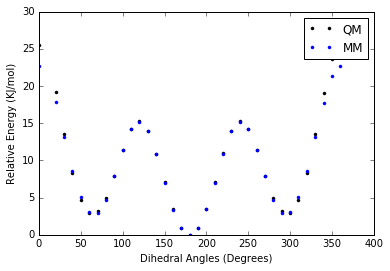

In [7]:
plt.plot(optimized.steps, optimized.qm_energy, 'k.', label='QM')
plt.plot(optimized.steps, optimized.mm_energy, '.', label='MM')
plt.xlabel('Dihedral Angles (Degrees)')
plt.ylabel('Relative Energy (KJ/mol)')
plt.legend()

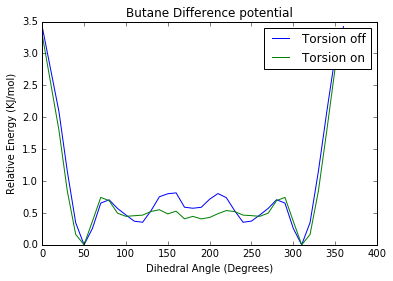

In [8]:
plt.plot(optimized_0.steps, optimized_0.delta_energy-min(optimized_0.delta_energy), label='Torsion off')
plt.plot(optimized.steps, optimized.delta_energy-min(optimized.delta_energy), label='Torsion on')
plt.legend()
plt.xlabel('Dihedral Angle (Degrees)')
plt.ylabel('Relative Energy (KJ/mol)')
plt.title('Butane Difference potential')

In [9]:
platform = mm.Platform.getPlatformByName('Reference')
model = Model.TorsionFitModelEliminatePhase(param, optimized_0, platform=platform, 
                                            param_to_opt=param_to_opt, sample_n5=True)
sampler = MCMC(model.pymc_parameters, db=sqlite_plus, dbname='butane_n5_init_0.db', verbose=5)

In [10]:
db = sqlite_plus.load('butane_n5_init_0.db')

In [6]:
sampler.sample(100000)

Assigning step method Metropolis to stochastic CG331_CG321_CG321_CG331_4_K
Assigning step method Metropolis to stochastic BUTA1_offset
Assigning step method Metropolis to stochastic CG331_CG321_CG321_CG331_1_K
Assigning step method Metropolis to stochastic CG331_CG321_CG321_CG331_6_K
Assigning step method Metropolis to stochastic CG331_CG321_CG321_CG331_2_K
Assigning step method Metropolis to stochastic CG331_CG321_CG321_CG331_5_K
Assigning step method Metropolis to stochastic CG331_CG321_CG321_CG331_3_K
Assigning step method DiscreteMetropolis to stochastic CG331_CG321_CG321_CG331_multiplicity_bitstring
Assigning step method Metropolis to stochastic log_sigma
 [-----------------100%-----------------] 100000 of 100000 complete in 8473.4 sec

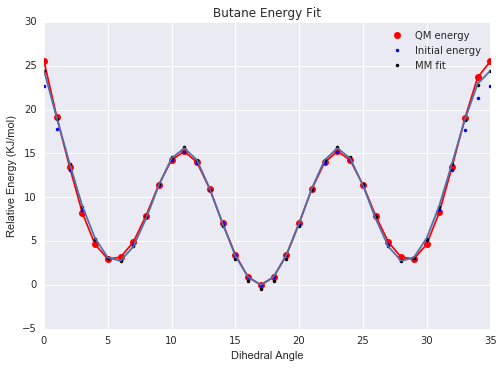

In [88]:
import seaborn
plt.plot(optimized.qm_energy, 'ro', label='QM energy')
plt.plot(optimized.qm_energy, color='r')
plt.plot(optimized.mm_energy, 'b.', label='Initial energy')
plt.plot(sampler.trace('mm_energy')[-1], 'k.', label='MM fit')

seaborn.tsplot(sampler.trace('mm_energy')[:])
plt.legend()
plt.xlabel('Dihedral Angle')
plt.ylabel('Relative Energy (KJ/mol)')
plt.title('Butane Energy Fit')
plt.savefig('sample_n5/Energy_fit_n5.pdf')

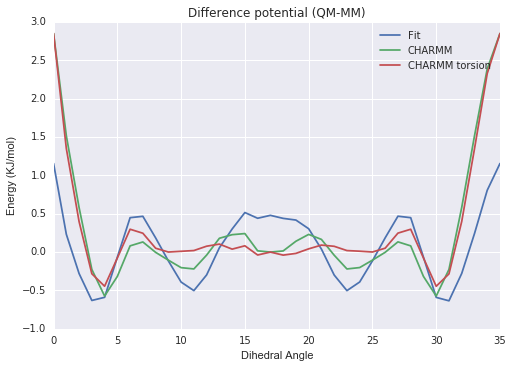

In [89]:
# reparameterize 
param_new = CharmmParameterSet('../data/charmm_ff/top_all36_cgenff.rtf', '../data/charmm_ff/par_all36_cgenff.prm')
# Turn off torsion
param_new.dihedral_types[('CG331', 'CG321', 'CG321', 'CG331')][1].phi_k=0
param_new.dihedral_types[('CG331', 'CG321', 'CG321', 'CG331')][0].phi_k=0

torsion_0 = optimized_0.remove_nonoptimized()
torsion_0.compute_energy(param_new)
plt.plot(optimized_0.delta_energy, label='Fit')
plt.plot(torsion_0.delta_energy, label='CHARMM')
plt.plot(optimized.delta_energy, label='CHARMM torsion')
plt.title('Difference potential (QM-MM)')
plt.xlabel('Dihedral Angle')
plt.ylabel('Energy (KJ/mol)')
plt.legend()
plt.savefig('sample_n5/diff_pot.png')
plt.savefig('sample_n5//diff_pot.pdf')

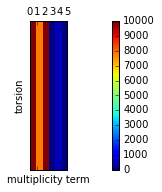

In [11]:
samples = 100000
burn = 0
multiplicities = (1,2,3,4,5,6)
import numpy as np
mult_bitstring = []
for i in model.pymc_parameters.keys():
    if i.split('_')[-1] == 'bitstring':
        mult_bitstring.append(i)

histogram = np.zeros((len(mult_bitstring), samples, 6))

for m, torsion in enumerate(mult_bitstring):
    for i, j in enumerate(db.trace('%s' % torsion)[burn:]):
        for k, l in enumerate(multiplicities):
            if 2**(l-1) & int(j):
                histogram[m][i][k] = 1

plt.matshow(histogram.sum(1), cmap='jet',  extent=[0, 5, 0, 20]), plt.colorbar()
plt.yticks([])
plt.xlabel('multiplicity term')
plt.ylabel('torsion')
#plt.savefig(filename)

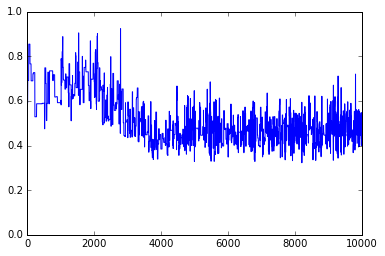

In [14]:
plt.plot(np.exp(db.log_sigma[:]))

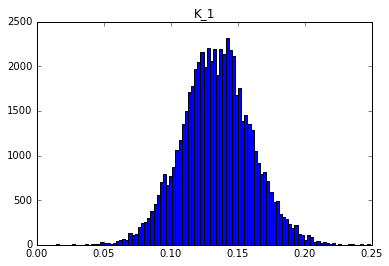

In [27]:
plt.hist(sampler.trace('CG331_CG321_CG321_CG331_1_K')[40000:], bins=100)
plt.title('K_1')

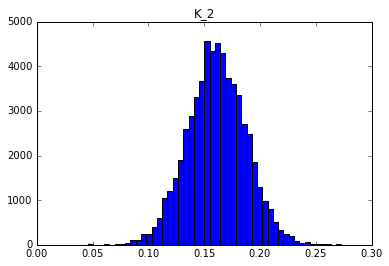

In [28]:
plt.hist(sampler.trace('CG331_CG321_CG321_CG331_2_K')[40000:], bins=50)
plt.title('K_2')

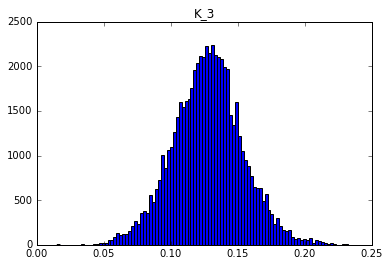

In [29]:
plt.hist(sampler.trace('CG331_CG321_CG321_CG331_3_K')[40000:], bins=100)
plt.title('K_3')

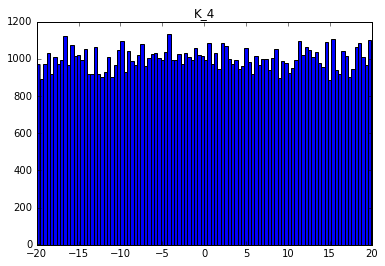

In [30]:
plt.hist(sampler.trace('CG331_CG321_CG321_CG331_4_K')[:], bins=100)
plt.title('K_4')

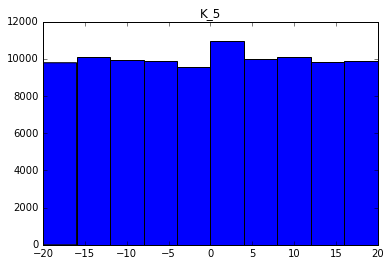

In [44]:
plt.hist(sampler.trace('CG331_CG321_CG321_CG331_5_K')[:])
plt.title('K_5')

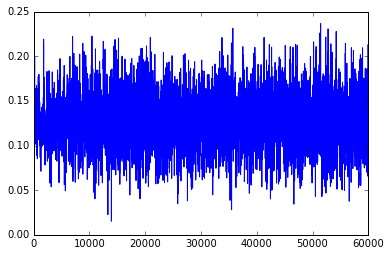

In [64]:
plt.plot(sampler.CG331_CG321_CG321_CG331_3_K.trace[40000:])

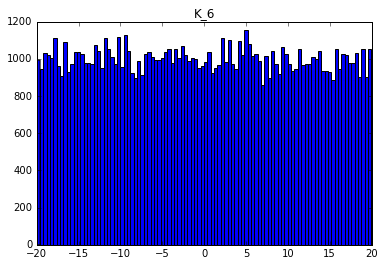

In [45]:
plt.hist(sampler.trace('CG331_CG321_CG321_CG331_6_K')[:], bins=100)
plt.title('K_6')

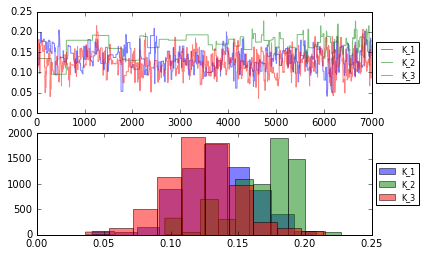

In [18]:
alpha=0.5
plt.subplot(2, 1, 1)
plt.plot(db.trace('CG331_CG321_CG321_CG331_1_K')[3000:], alpha=alpha, label='K_1')
plt.plot(db.trace('CG331_CG321_CG321_CG331_2_K')[3000:], alpha=alpha, label='K_2')
plt.plot(db.trace('CG331_CG321_CG321_CG331_3_K')[3000:], alpha=alpha, label='K_3')
#plt.plot(db.trace('CG331_CG321_CG321_CG331_4_K')[4000:], alpha=alpha, label='K_4')
#plt.plot(db.trace('CG331_CG321_CG321_CG331_6_K')[:], alpha=0.4)
lgd = plt.legend(prop={'size': 8}, loc='center left', bbox_to_anchor=(1, 0.5))



plt.subplot(2, 1, 2)
plt.hist(db.trace('CG331_CG321_CG321_CG331_1_K')[3000:], alpha=alpha, label='K_1')
plt.hist(db.trace('CG331_CG321_CG321_CG331_2_K')[3000:], alpha=alpha, label='K_2')
plt.hist(db.trace('CG331_CG321_CG321_CG331_3_K')[3000:], alpha=alpha, label='K_3')
#plt.hist(db.trace('CG331_CG321_CG321_CG331_4_K')[3000:], alpha=alpha, label='K_4')
lgd = plt.legend(prop={'size': 8}, loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig('trace_hist.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')

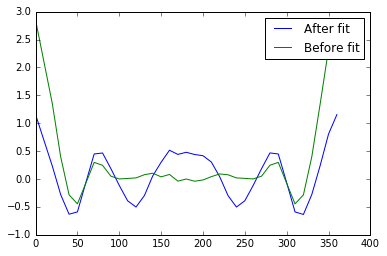

In [66]:
#plt.plot(sampler.trace('mm_energy')[-1])
#plt.plot(optimized_0.mm_energy)
plt.plot(optimized_0.steps, optimized_0.delta_energy, label='After fit')
plt.plot(optimized.steps, optimized.delta_energy, label='Before fit')

plt.legend()

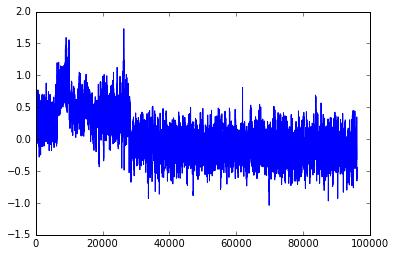

In [51]:
plt.plot(sampler.BUTA1_offset.trace[4000:])

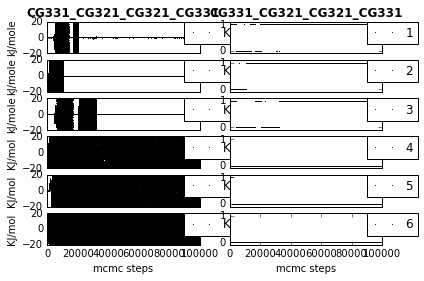

In [52]:
plots.trace_no_phase_n5('CG331_CG321_CG321_CG331', sampler, equil=False, markersize=1.0, filename='trace_n5_init0.pdf')

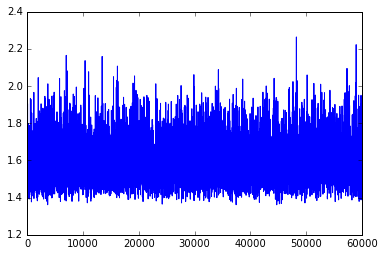

In [55]:
plots.get_multiplicity_traces

In [76]:
len(x)

32